In [1]:
import cv2 as cv
from matplotlib import pyplot as plt
import numpy as np

# Laden eines Bildes in eigenem Fenster

In [2]:
img = cv.imread('./img/lena.jpg', -1)
cv.imshow('image', img)
k = cv.waitKey(0)
# Kernel ist während Anzeige des Bildes beschäftigt!
cv.destroyAllWindows()

# Laden eines Bildes im Jupyter Notebook

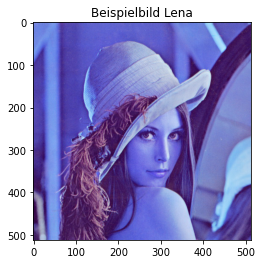

In [3]:
%matplotlib inline
img = cv.imread('./img/lena.jpg', -1)
plt.imshow(img)
plt.title('Beispielbild Lena')
plt.show()

# Warum ist das Bild farbfremd? 
Wir arbeiten aktuell im Farbraum Rot-Grün-Blau. 
- Bildverarbeitungsbib. OpenCV arbeitet mit der Reihenfolge Blau-Grün-Rot
- Inline-Visualisierungsbib. Matplotlib arbeitet mit der Reihenfolge Rot-Grün-Blau
Eine Umwandlung des Farbraumes BGR2RGB ist somit notwendig.

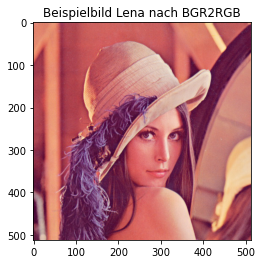

In [4]:
img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.title('Beispielbild Lena nach BGR2RGB')
plt.show()

# Zugriff auf die Farbkanäle

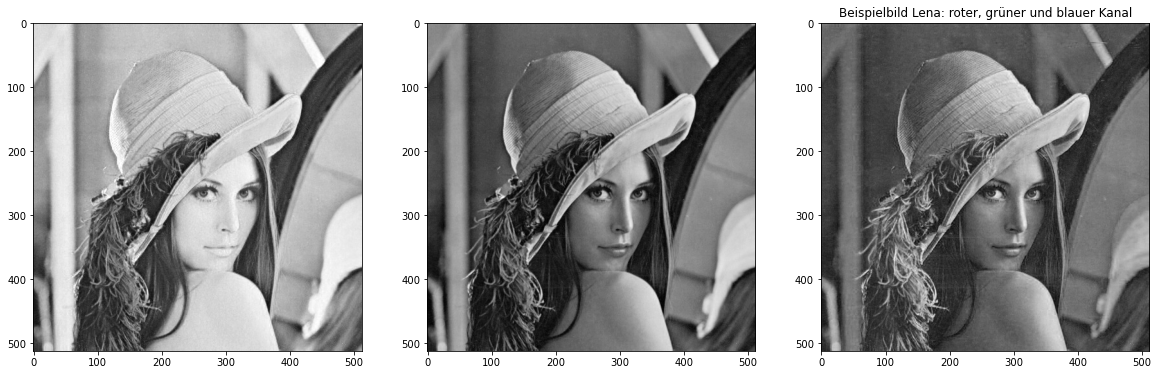

In [5]:
img_r = img_rgb[:, :, 0]
img_g = img_rgb[:, :, 1]
img_b = img_rgb[:, :, 2]
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))
ax1.imshow(img_r, cmap='gray')
ax2.imshow(img_g, cmap='gray')
ax3.imshow(img_b, cmap='gray')
plt.title('Beispielbild Lena: roter, grüner und blauer Kanal')
plt.show()

# Umwandlung von RGB in Grauwerte

Max. Wert:  239.25


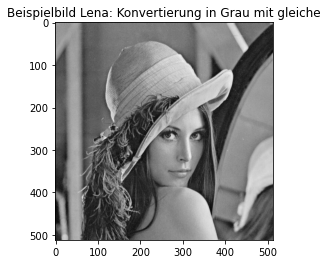

In [6]:
img_gray = np.dot(img_rgb[..., :3], [0.33, 0.33, 0.33])
print('Max. Wert: ', np.max(img_gray))

plt.imshow(img_gray, cmap='gray')
plt.title('Beispielbild Lena: Konvertierung in Grau mit gleiche')
plt.show()

## Vergleiche eigene Konvertierung mit OpenCV Konvertierung

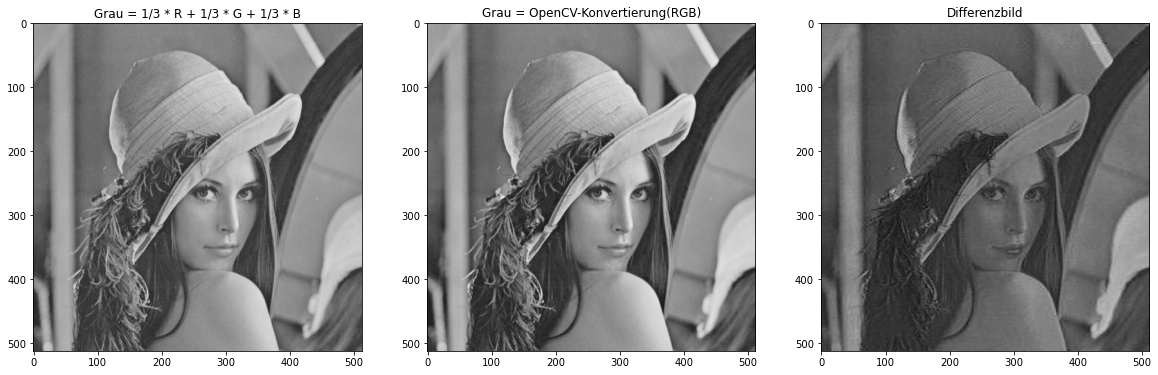

Absoluter Fehler:  1445834.49


In [7]:
img_gray_cv = cv.cvtColor(img_rgb, cv.COLOR_RGB2GRAY)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))
# linkes Bild: eigene Konvertierung
# rechtes Bild: OpenCV Konvertierung
ax1.imshow(img_gray, cmap='gray', vmin=0, vmax=255)
ax1.set_title('Grau = 1/3 * R + 1/3 * G + 1/3 * B')
ax2.imshow(img_gray_cv, cmap='gray', vmin=0, vmax=255)
ax2.set_title('Grau = OpenCV-Konvertierung(RGB)')
# Differenz der Bilder berechnen
img_diff = img_gray_cv - img_gray
ax3.imshow(img_diff, cmap='gray')
ax3.set_title('Differenzbild')
plt.show()
err_gray_conversion = np.round(np.sum(np.abs(img_diff)), 2)
print('Absoluter Fehler: ', err_gray_conversion)

Die eigene Konvertierung mit der gleichen Gewichtung der einzelnen Farbkanäle entspricht nicht der Grauwertkonvertierung durch OpenCV. 

**Warum ist dies so?**

Der Grün-Anteil im menschlichen Auge hat den größten Einfluss auf die Helligkeitswahrnehmung. Daher wird der grüne Kanal bei der Grauwertbildung entsprechend des YUV-Modells höher gewichtet. (Auch der Bayer-Kamerasensor besteht dadurch aus einem zu 50 % grün-sensitivem Bereich, während sich die anderen 50 % auf rot und blau aufteilen.)

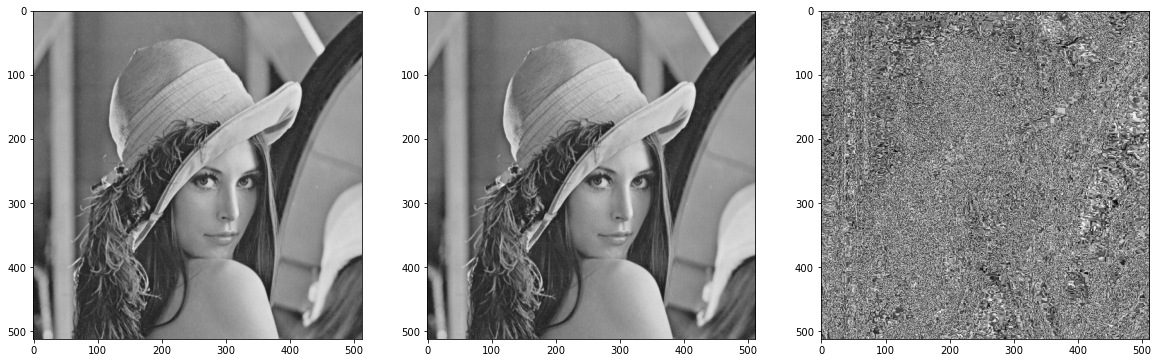

Absoluter Fehler:  42783.38
Unterschied beider Fehler (gleich-gewichteter Grauwert und YUV-Gewichtung):
1445834.49  /  42783.38  =  33.79


In [8]:
# Neue Berechnung der Grauwerte durch Gewichtung gemäß YUV
img_gray_new = np.dot(img_rgb[..., :3], [0.299, 0.587, 0.114])
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))
ax1.imshow(img_gray_new, cmap='gray', vmin=0, vmax=255)
ax2.imshow(img_gray_cv, cmap='gray', vmin=0, vmax=255)

# Differenz der Bilder berechnen
img_diff = img_gray_cv - img_gray_new
ax3.imshow(img_diff, cmap='gray')
plt.show()
err_gray_conversion_new = np.round(np.sum(np.abs(img_diff)), 2)
print('Absoluter Fehler: ', err_gray_conversion_new)
print('Unterschied beider Fehler (gleich-gewichteter Grauwert und YUV-Gewichtung):')
print(err_gray_conversion, ' / ', err_gray_conversion_new, ' = ',
      np.round(err_gray_conversion / err_gray_conversion_new, 2))

# Filtern nach Farbe
In diesem Teil wird das RGB-Bild nach dem blau/lilanem Hut-Accessoire gefiltert.

## Zuerst Funktionen zum Erstellen von Histogrammen und Farbfiltermethoden
Dadurch wird das spätere Vorgehen der Farbfilterung erheblich vereinfacht

In [9]:
# Function to create a histogram
def create_histogram(hsv_img):
    color = ('r', 'g', 'b')

    # Neuen Plot erstellen
    plt.figure()
    for i, col in enumerate(color):
        # Erstelle Histogramm für Hue, Saturation und Value
        histogram = cv.calcHist([hsv_img], [i], None, [256], [0, 256])
        plt.plot(histogram, color=col)
        plt.xlim([0, 256])

    # Zeige das generierte Histogramm mit Hue, Saturation und Value an
    plt.title('Farbwerthistogramm (rot = hue, grün = sat., blau = val.)')
    plt.show()

# Function to filter and show images
def filterColor(imgHSV, imgRGB, lowerBounds, upperBounds, show=True):
    # Filter Farben auf HSV Bild
    filtered_hsv = cv.inRange(imgHSV, lowerBounds, upperBounds)

    # Filter Farben auf RGB, indem nur Pixel kopiert werden, wo das gefilterte HSV auch Pixel hat
    filtered_rgb = imgRGB.copy()
    filtered_rgb[np.where(filtered_hsv == 0)] = 0

    # Falls gewünscht, anzeigen der Bilder nebeneinander
    if show:
        plt.figure(figsize=(20, 10))
        plt.subplot(1, 2, 1)
        plt.imshow(filtered_hsv)
        plt.title('Gefilterte Bildbereiche im HSV-Raum')
        plt.subplot(1, 2, 2)
        plt.imshow(filtered_rgb)
        plt.title('Gefilterte Bildbereiche im RGB-Raum')
        plt.show()

    # Zurückgeben der gefilterten Bilder
    return filtered_hsv, filtered_rgb

Nun zur eigentlichen Farbfilterung

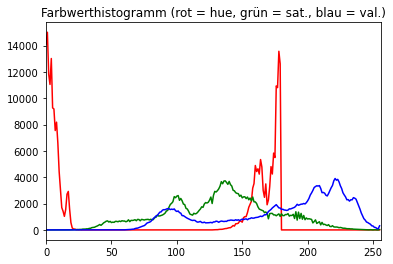

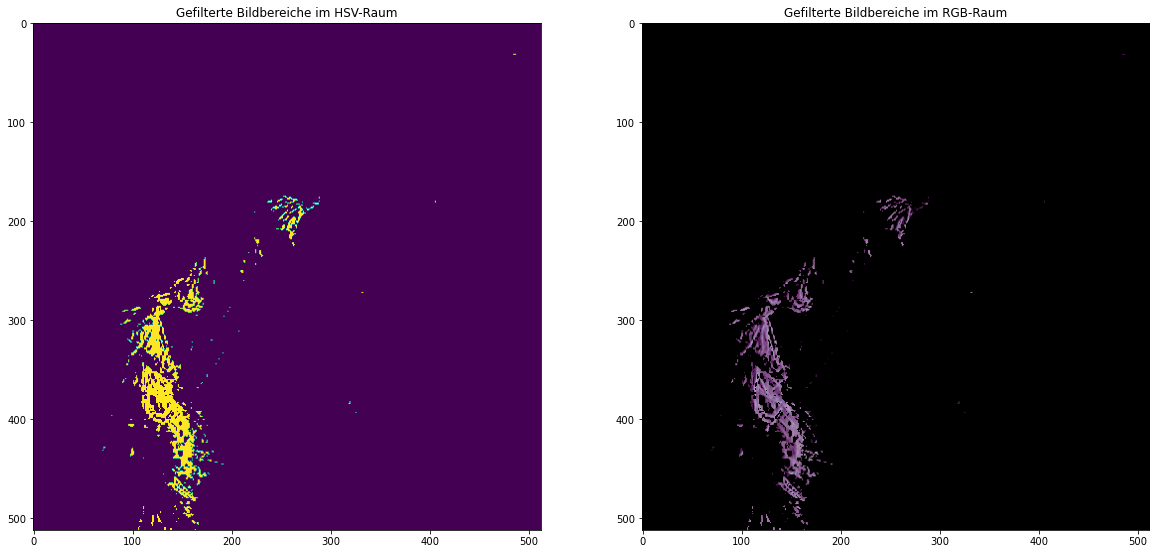

In [10]:
# konvertiere RGB zu HSV
img_hsv = cv.cvtColor(img_rgb, cv.COLOR_RGB2HSV)

# betrachte zunächst Histogramm des Bildes, um Farbwerte näher zu analysieren
create_histogram(img_hsv)

# filtere blauen Anteil heraus
_, _ = filterColor(img_hsv, img_rgb, (80, 50, 50), (150, 255, 255))

## Aufgabe: Filtern Sie die gelbe (+weiße) Spurmarkierung aus dem Eingangsbild

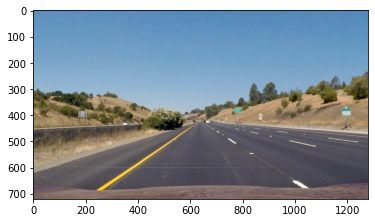

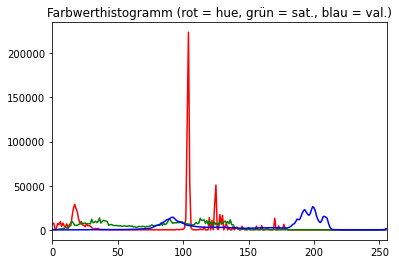

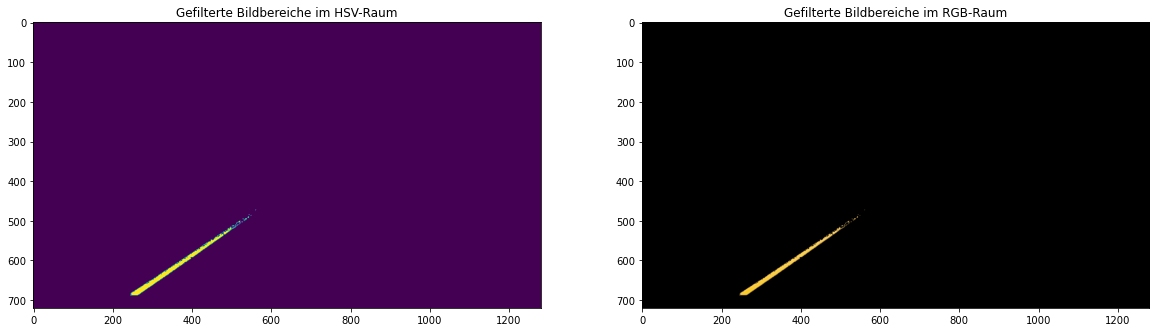

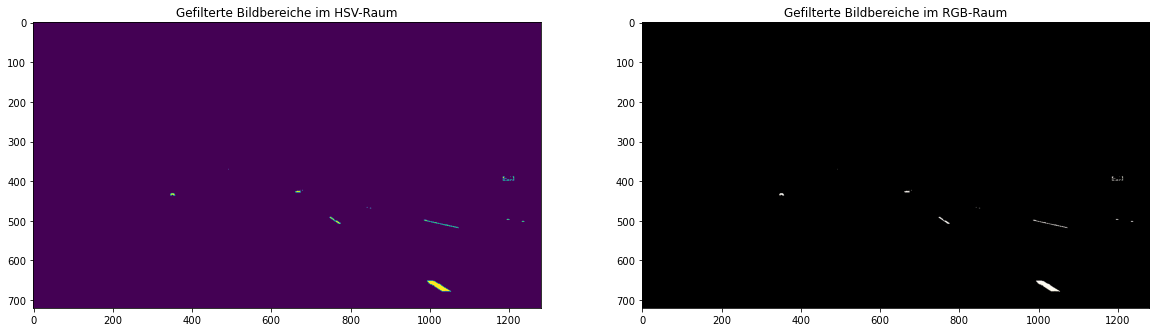

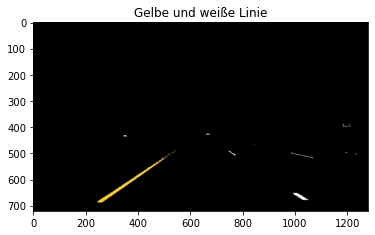

In [11]:
# lade das Bild mit Spurmarkierungen und zeige es an
img_lane = cv.imread('./img/image001.jpg', -1)
img_lane = cv.cvtColor(img_lane, cv.COLOR_BGR2RGB)
plt.figure()
plt.imshow(img_lane)
plt.show()

# HSV Variante anlegen
img_lane_hsv = cv.cvtColor(img_lane, cv.COLOR_RGB2HSV)

# Zuerst Histogramm erstellen, um gelbe Farbwerte zu analysieren
create_histogram(img_lane_hsv)

# Gelb ist "Spike" um 30 herum
_, yellow_line = filterColor(img_lane_hsv, img_lane, (20, 140, 140), (30, 255, 255))

# Weiße Linie
_, white_line = filterColor(img_lane_hsv, img_lane, (0, 0, 220), (50, 20, 255))

# Kombinieren der gefilterten Bilder
plt.imshow(cv.bitwise_or(yellow_line, white_line))
plt.title("Gelbe und weiße Linie")
plt.show()

## Aufgabe: Wenden Sie Ihr wissen auf Tempolimits an
Bitte heben Sie in folgenden Bildern die Tempolimits mit Ihrem gelernten Wissen hervor.
Die Bilder sind der German Traffic Sign Detection Benchmark (GTSDB) entnommen.
[Link zum GTSDB](https://sid.erda.dk/public/archives/ff17dc924eba88d5d01a807357d6614c/published-archive.html)

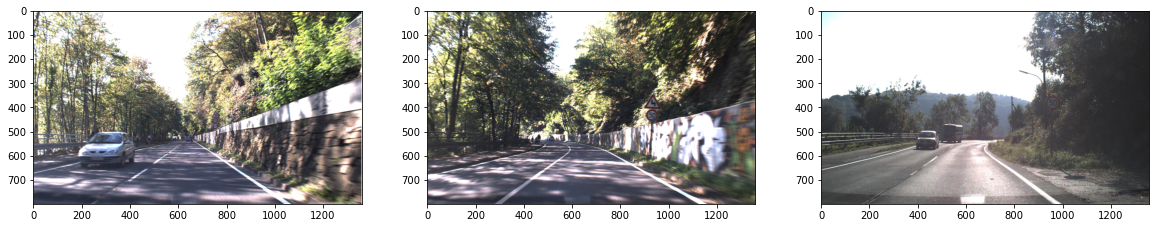



1. Bild:


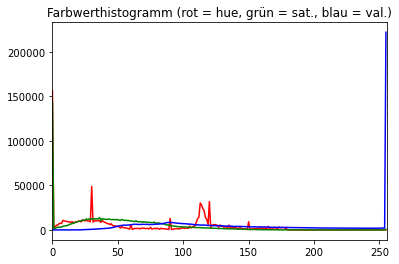

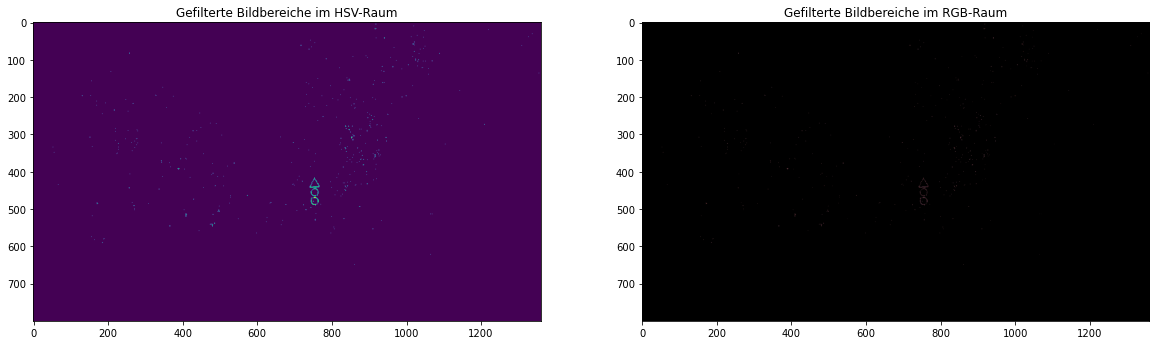



2. Bild:


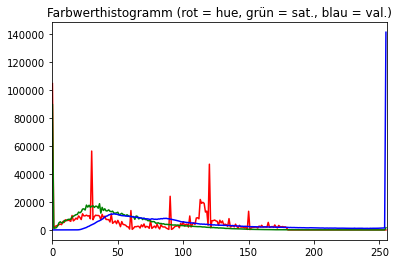

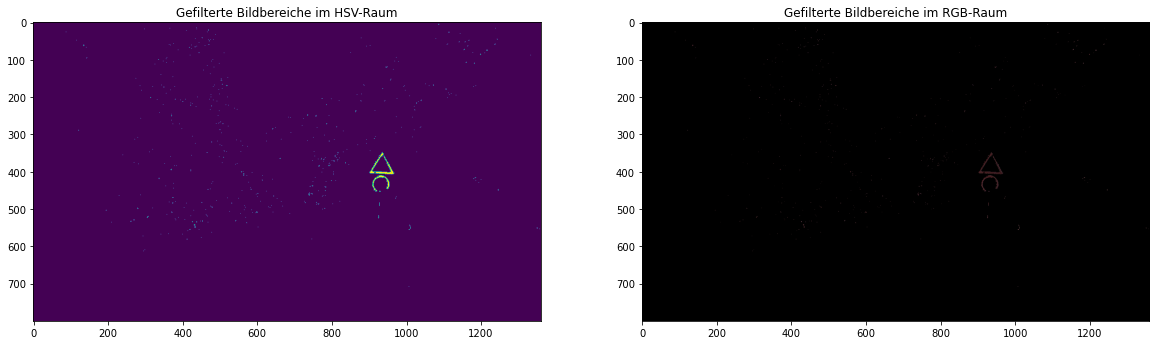



3. Bild:


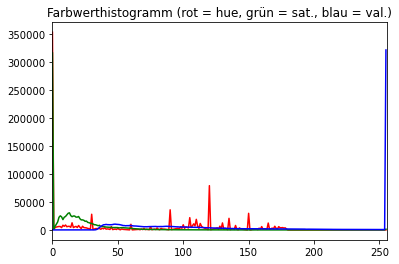

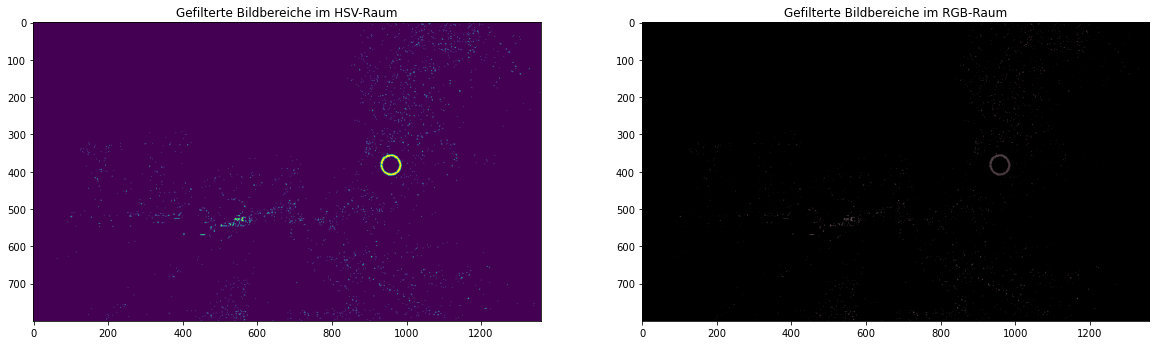

In [14]:
# lade Bilder mit Tempolimits und zeige diese an
img1 = cv.cvtColor(cv.imread('./img/00003.bmp', -1), cv.COLOR_BGR2RGB)
img2 = cv.cvtColor(cv.imread('./img/00004.bmp', -1), cv.COLOR_BGR2RGB)
img3 = cv.cvtColor(cv.imread('./img/00006.bmp', -1), cv.COLOR_BGR2RGB)

# Anzeigen der Bilder nebeneinander
plt.figure(figsize=(20, 30))
plt.subplot(1, 3, 1)
plt.imshow(img1)
plt.subplot(1, 3, 2)
plt.imshow(img2)
plt.subplot(1, 3, 3)
plt.imshow(img3)
plt.show()

# Liste aus Straßenschild-Bildern
sign_images = [img1, img2, img3]

# Für jedes Bild HSV-Bereiche festlegen
bounds = {
    0: [(160, 80, 50), (180, 150, 200)],
    1: [(160, 80, 50), (180, 160, 200)],
    2: [(160, 40, 50), (200, 170, 200)],
}

for i, sign in enumerate(sign_images):
    # Konvertierung des Bildes in HSV
    sign_hsv = cv.cvtColor(sign, cv.COLOR_RGB2HSV)

    print(f"\n\n{i + 1}. Bild:")
    # Histogramm erstellen
    create_histogram(sign_hsv)

    # Nach Rot filtern mit den oben festgelegten Bereichen
    img_bounds = bounds[i]
    red_hsv, red_rgb = filterColor(sign_hsv, sign, img_bounds[0], img_bounds[1])

    # Zu viele ungewollte Bereiche durch Filtern von Weiß um Schildhintergrund auch anzuzeigen
    #white_hsv, white_rgb = filterColor(sign_hsv, sign, (100, 0, 20), (150, 50, 100))
    #plt.imshow(cv.bitwise_or(red_rgb, white_rgb, red_hsv))
    #plt.show()
